$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 3: Neural Network Regression

Bradley Pospeck

## Overview

In this assignment, I will be comparing linear and non-linear models applied to a 3D road network dataset. For the linear portion, ridge regression will be used. To obtain the weights of the attributes, the following equation will be used:

$$ \wv = (X^T X + \lambda I)^{-1} X^T T $$

where:

$$
    \lambda I =
     \begin{bmatrix}
     0 & 0 & \dotsc & 0\\
       0 & \lambda & \dotsc & 0\\
       \vdots \\
       0 & 0 & \dotsc & \lambda
    \end{bmatrix}
$$

For the non-linear portion, neural networks will be used. The following equations are used for this neural network:

    The forward pass equations:
    
$$
    \begin{align*}
      \Zv &= h(\tilde{\Xv} \Vv)\\
      \Yv &= \tilde{\Zv} \Wv\\
    \end{align*}
$$
    
    The backward pass for V:
    
$$
    \begin{align*}
     \Vv & \leftarrow \Vv + \rho_h \frac{1}{N} \frac{1}{K} \tilde{\Xv}^T \left ( (\Tv - \Yv) \hat{\Wv}^T \cdot  (1-\Zv^2) \right )\\
    \end{align*}
$$
    
    The backward pass for W:
    
$$
    \begin{align*} 
     \Wv & \leftarrow \Wv + \rho_o \frac{1}{N}  \frac{1}{K}\tilde{\Zv}^T (\Tv - \Yv)
    \end{align*}
$$

## Imports and Extras

In [1]:
import itertools
import neuralnetworks as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The following python files are used in conjunction with this notebook file:

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

## Functions

`trainLinear` takes a data input matrix, `X`, a target matrix, `T`, and a $\lambda$ input, `parameters`. It will create a linear model that returns the means, standard deviations, and weights in a dictionary.

In [2]:
def trainLinear(X,T,parameters):
    """Standardizes the inputs, X, before calculating the means, standard deviations, 
and weights which are all returned in a dictionary. Performs ridge regression."""
    mean = np.mean(X,axis=0)
    std = np.std(X,axis=0)
    # below for loop standardizes the inputs before calculating w
    cols = X.shape[1]
    Z = np.empty(X.shape)
    for c in range(cols):
        Z[:,c] = (X[:,c]-mean[c]) / std[c]
    # Now insert column of 1's in front to account for w0
    Z1 = np.insert(Z, 0, 1, axis=1)
    # Setup diagonal lambda matrix
    D = Z1.shape[1]
    lambdaDiag = np.eye(D) * parameters
    lambdaDiag[0,0] = 0
    w = np.linalg.lstsq(np.dot(Z1.T,Z1) + lambdaDiag,np.dot(Z1.T,T))[0]
    return {'means': mean, 'stds': std, 'w': w}

The function `evaluateLinear` takes an input `model`, as well as `X` and `T` matrices. It will find the root mean squared error associated with the model and return that as `rmse`.

In [3]:
def evaluateLinear(model,X,T):
    """Uses the returned dictionary from trainLinear in order to calculate 
and return rmse"""
    Z = np.empty(X.shape)
    # Standardize X again
    cols = X.shape[1]
    for c in range(cols):
        Z[:,c] = (X[:,c] - model['means'][c]) / model['stds'][c]
    # insert column of 1's
    Z1 = np.insert(Z, 0, 1, axis=1)
    output = np.dot(Z1,model['w'])
    error = output - T
    sError = error **2
    msError = np.mean(sError, axis=0)
    rmse = np.sqrt(msError)
    return rmse

The function `trainNN` takes the same inputs as `trainLinear`. The only difference with the inputs is that `parameters` in this case contains both the hidden layers and hidden units for the neural network along with the number of iterations. This function simply constructs a neural network using `neuralnetworks.py` and calls the `train` method on that object before returning that object.

Here are some examples demonstrating the parameters:
```
model = trainNN(X,T,[5, 100])       # Single hidden layer of 5 units, trained 
                                    # for 100 iterations
model = trainNN(X,T,[[10,10], 200]) # Two hidden layers, 10 units each, 
                                    # trained for 200 iterations
```

In [4]:
def trainNN(X,T,parameters):
    #print('hidden layers: {}'.format(parameters[0]))
    #print('nIterations: {}'.format(parameters[1]))
    nnet = nn.NeuralNetwork(X.shape[1],parameters[0],T.shape[1])
    nnet.train(X,T,nIterations=parameters[1])
    return nnet

`evaluateNN` takes the same inputs as `evaluateLinear` except that the `model` input is the neural network object created by `trainNN` above. It also calculates and returns `rmse`.

In [5]:
def evaluateNN(model,X,T):
    out = model.use(X)
    error = out - T
    sErr = error **2
    msErr = np.mean(sErr, axis=0)
    rmse = np.sqrt(msErr)
    return rmse

The final function, `trainValidateTestKFolds`, takes several input parameters. It takes 2 function inputs that will be the `train` and `evaluate` functions for either the linear or neural network functions above. It then takes both `X` and `T` matrices as well as the `parameterSets` provided based on whether or not the linear regression or neural networks will be used. The `nFolds` input determines how many folds will be used when partitioning the data. `shuffle` determines if the data is shuffled before being partitioned or not. `verbose` being true will print out the best result from each `testFold`.

The function iterates over all possible test and validate folds to find which produces the smallest average validation error. Then, the train and validation sets will be combined in order to retrain the best model. Those best results are then stored in a list of best parameter values with this training error, the mean of the above valdiation errors, and the testing error.

Finally, the function returns a list of all of the aforementioned lists.

In [6]:
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,
                            shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []
    
    for testFold in range(nFolds):
        bestErr = 1000000
        bestParm = 0
        for parmSet in parameterSets:  # For each set of parameter values, called parmSet
            valErrors = []
            # Find best set of parameter values
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # Pulled from partition code on A2
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Use trainf to fit model to training data using parmSet
                model = trainf(Xtrain,Ttrain,parmSet)
                # Calculate the error of this model by calling evaluatef with 
                #  the model and validation data
                valErrors.append(evaluatef(model,Xvalidate,Tvalidate))
            meanError = sum(valErrors) / float(len(valErrors))
            # If this error is less than the previously best error for parmSet, 
            # update best parameter values and best error
            if meanError < bestErr:
                bestErr = meanError
                bestParm = parmSet
        # Make a new set of training data by concatenating the training and 
        # validation data from previous step.
        Xtrain = np.vstack((Xtrain,Xvalidate))
        Ttrain = np.vstack((Ttrain,Tvalidate))
        # Retrain, using trainf again, to fit a new model using the best set of parameter values
        #  found above, to this new training data.
        model = trainf(Xtrain,Ttrain,bestParm)
        # Calculate error of this new model on the test data, and also on the new 
        #  training data.
        testErr = evaluatef(model,Xtest,Ttest)
        trainErr = evaluatef(model,Xtrain,Ttrain)
        # Construct a list of the best parameter values with this training error, 
        #  the mean of the above valdiation errors, and the testing error. The mean of
        #  the above validation errors means the mean error over the validation folds for
        #  the best parameter values found.  So, nothing to recalculate.  Just use the mean
        #  validation set error from above that was used to pick the best parameter values.
        result = [bestParm,trainErr,bestErr,testErr]
        if verbose == True:
            print(result)
        results.append(result)
    return results

## Data

My dataset is a [3D road network](http://archive.ics.uci.edu/ml/datasets/3D+Road+Network+%28North+Jutland%2C+Denmark%29) in Denmark.

Attribute Information:
    1. OSM_ID: OpenStreetMap ID for each road segment or edge in the graph. 
    2. Longitude: Web Mercaptor (Google format) longitude 
    3. Latitude: Web Mercaptor (Google format) latitude 
    4. Altitude: Height in meters. 
The first 3 attributes will be used to predict heights in the area with latitude and longitude. I thought it would be interesting to see how well altitude could be predicted with only 3 input attributes, especially with the 2 different methods in this assignment. I am expecting the neural networks to do a better job of predicting height than the linear regression. I don't think geographical features would necessarily be linear.

In [7]:
data = np.genfromtxt('3D_spatial_network.txt', delimiter=',')
data.shape

(434874, 4)

In [8]:
X = data[:,0:3]

In [9]:
T = data[:,3:]

In [10]:
X,T

(array([[  1.44552912e+08,   9.34984860e+00,   5.67408757e+01],
        [  1.44552912e+08,   9.35018840e+00,   5.67406785e+01],
        [  1.44552912e+08,   9.35054850e+00,   5.67405445e+01],
        ..., 
        [  9.33232050e+07,   9.93500950e+00,   5.74992821e+01],
        [  9.33232090e+07,   9.94347870e+00,   5.74959190e+01],
        [  9.33232090e+07,   9.94345120e+00,   5.74962700e+01]]),
 array([[ 17.05277157],
        [ 17.61484024],
        [ 18.08353564],
        ..., 
        [ 19.73314057],
        [ 24.02701497],
        [ 24.63528478]]))

Alright, data looks good and is separated appropriately. Since there are almost 435,000 data points per column, I'm going to delete data as it's now wasting a lot of space.

In [11]:
del data

In [12]:
Xnames = ['OSM_ID','Longitude','Latitude']
Tname  = 'Altitude'

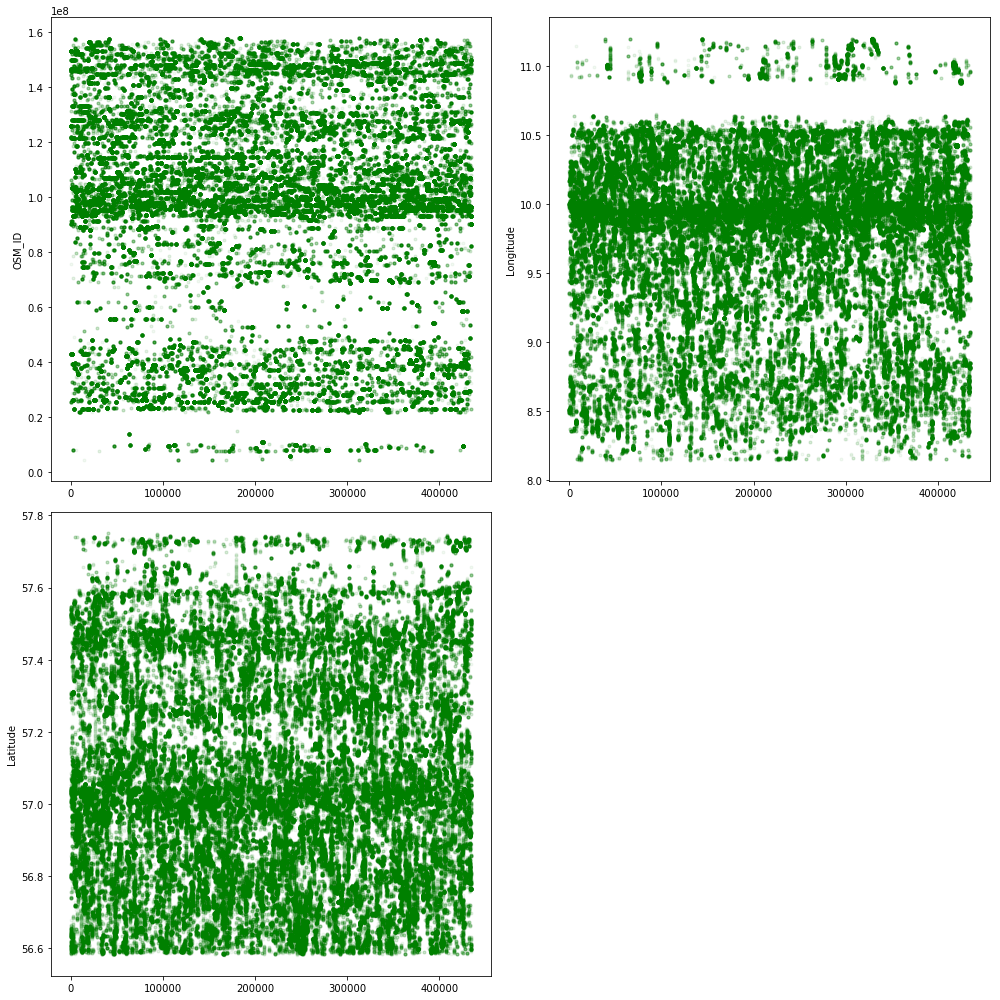

In [13]:
plt.figure(figsize=(14,14))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(2,2, c+1)
    plt.plot(X[:,c], 'g.',alpha=.05)
    plt.ylabel(Xnames[c])
plt.tight_layout()

There are so many data points, it's not really feasible to look at the plots of data and make observations. I will plot all values versus the targets to see if I can notice anything though.

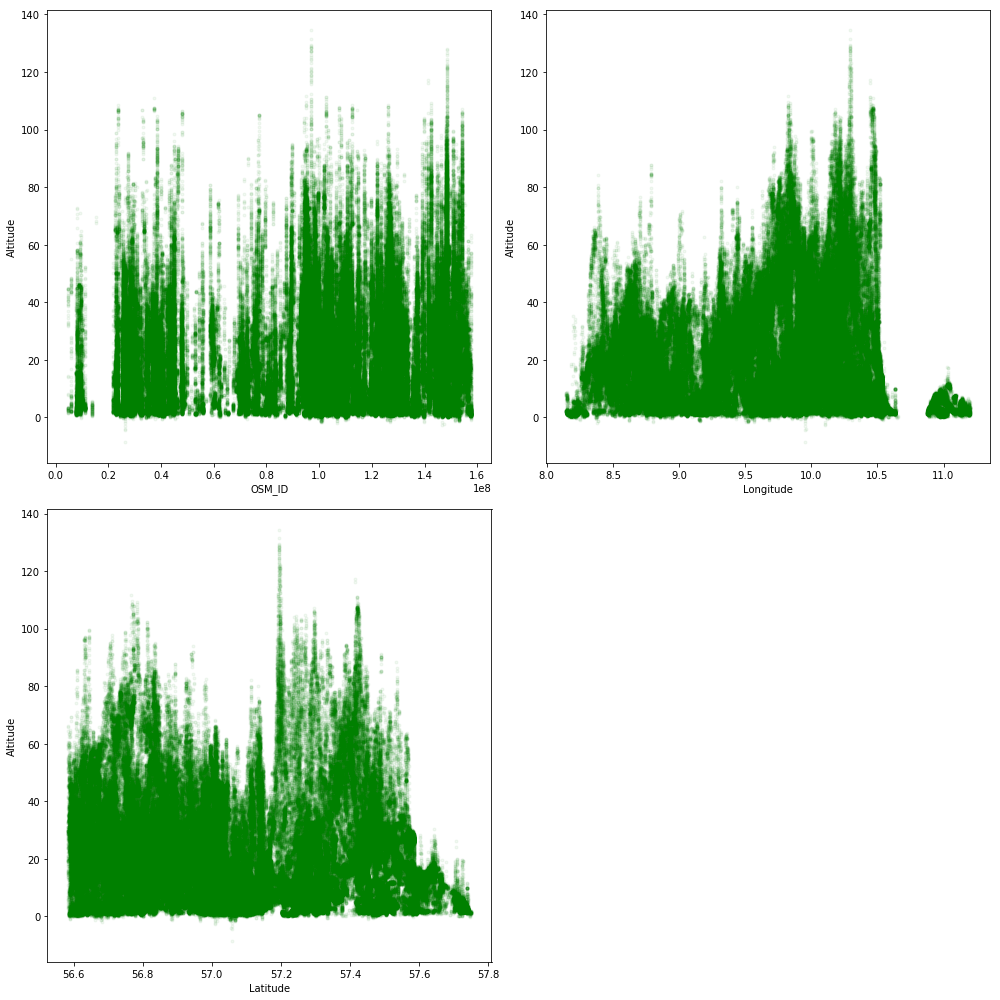

In [14]:
plt.figure(figsize=(14,14))
nrow,ncol = X.shape
for c in range(ncol):
    plt.subplot(2,2, c+1)
    plt.plot(X[:,c],T, 'g.', alpha=.05)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
plt.tight_layout()

Aside from the small cluster around 11.0 longitude, it looks like there may be a somewhat proportional relationship between longitude and altitude. An inversely proportional relationship looks like a possibility between latitude and altitude. The OSM_ID is much more sporadic and is probably going to be the least important attribute to consider. With such a large range of altitudes, it does not seem like any of these relationships would be linear.

## Results
#### Using Linear Regression

Let's just start by testing linear with $\lambda$ in increments of 10 from 0-100.

In [15]:
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(0,101,10), nFolds=5, shuffle=False)
                                 
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(x[0],x[1][0],x[2][0],x[3][0]))

Linear Model
  lambda        train   validate  test RMSE
  100.00       18.204     18.227     18.555
  100.00       18.204     18.229     18.552
  100.00       18.261     18.293     18.317
  100.00       18.084     18.108     19.026
  100.00       18.581     18.617     16.995


Since $\lambda$ was 100 in every case, I'd like to try the next set of 100 to see if errors improve.

In [16]:
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(100,201,10), nFolds=5, shuffle=False)
                                 
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(x[0],x[1][0],x[2][0],x[3][0]))

Linear Model
  lambda        train   validate  test RMSE
  200.00       18.204     18.227     18.555
  200.00       18.204     18.229     18.552
  200.00       18.261     18.293     18.317
  200.00       18.084     18.108     19.025
  200.00       18.581     18.617     16.995


It looks like errors have already converged, and not at very good values either. This supports the idea that this data isn't likely very linear. Just to double check on convergence, I will use values of $\lambda$ up to 1000 next.

In [17]:
result = trainValidateTestKFolds(trainLinear, evaluateLinear ,X, T, range(500,1001,100), nFolds=5, shuffle=False)
                                 
print('Linear Model\n{:^10s} {:>10s} {:>10s} {:>10s}'.format('lambda', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:^10.2f} {:>10.3f} {:10.3f} {:10.3f}'.format(x[0],x[1][0],x[2][0],x[3][0]))

Linear Model
  lambda        train   validate  test RMSE
 1000.00       18.204     18.227     18.555
 1000.00       18.204     18.229     18.553
 1000.00       18.261     18.293     18.317
 1000.00       18.084     18.107     19.024
 1000.00       18.581     18.617     16.995


Convergence confirmed. Not much else to do with the linear functions at this point as the neural networks should yield more interesting results.

In [18]:
del result

#### Using Neural Networks

*Note:* I tried running neural networks for at least 15 minutes a piece before dropping a parameter and trying again. This is the largest one I could get to finish running after a couple hours of trying variations. 

In [22]:
parms = list(itertools.product([2,5], [10,100]))
result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, parms, nFolds=5, shuffle=False)
print('NN Model\n{:>30s} {:>10s} {:>10s} {:>10s}'.format('(Hidden Units, Iterations)', 'train', 'validate', 'test RMSE'))
for x in result:
    print('{:>30s} {:10.3f} {:10.3f} {:10.3f}'.format(str(x[0]), x[1][0],x[2][0],x[3][0]))

NN Model
    (Hidden Units, Iterations)      train   validate  test RMSE
                      (5, 100)     14.159     14.955     13.774
                      (5, 100)     14.016     14.099     14.468
                      (5, 100)     13.945     14.266     14.661
                      (5, 100)     14.068     14.054     14.277
                      (5, 100)     14.193     15.084     13.570


Although I could not run many hidden units or do multiple layers, I still ended up with errors smaller than the linear ones. I'm sure if I had a lot of time to test with more units, layers, and iterations I could reduce the RMSE values quite a bit more. It makes sense that 5 hidden units over 100 iterations would produce the best result out of the meager 4 I could test. 

## Grading

In [25]:
%run -i "A3grader.py"

 Testing: result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,
                  range(0,101,10),nFolds=5,shuffle=False)
 Your result is
    10   3.158   4.132   2.414
    20   4.368   5.021   3.641
    10   3.245   4.178   5.03
    20   4.448   6.07   2.024
    20   2.426   2.972   10.89
20/20 points. First column, of best lambda values, is correct.
20/20 points. Columns of RMSE values are correct.

 Testing:
   import itertools
   parms = list(itertools.product([[5],[5,5],[2,2,2]], [10,50,100,200]))
   te = []
   for rep in range(5):
       result = trainValidateTestKFolds(trainNN,evaluateNN,X,T,
                                        parms,
                                        nFolds=4,shuffle=False)
       resulte = np.array([r[1:] for r in result])
       meanTestRMSE = resulte[:,-1].mean()
       print('     ',meanTestRMSE)
       te.append(meanTestRMSE)
      2.02039926778
      2.14274059911
      2.27773817771
      1.95938785483
      1.87792340528
40/40 point